<a href="https://colab.research.google.com/github/cordmaur/Fastai2-Medium/blob/master/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
%pip install -Uq fastai
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

In [3]:
import fastai
fastai.__version__

'2.5.6'

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)

In [16]:
path.as_posix()

'/root/.fastai/data/mnist_sample'

In [9]:
#hide
Path.BASE_PATH = path

In [13]:
path.as_posix()

'/root/.fastai/data/mnist_sample'

In [10]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [ ]:
(path/'train').ls()

In [22]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [23]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [24]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [25]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [26]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [29]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

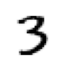

In [30]:
show_image(three_tensors[1]);

In [31]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [32]:
len(stacked_threes.shape)

3

In [33]:
stacked_threes.ndim

3

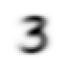

In [34]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

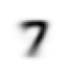

In [35]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

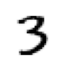

In [36]:
a_3 = stacked_threes[1]
show_image(a_3);

In [37]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [38]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [39]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## Computing Metrics Using Broadcasting

In [40]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [41]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [42]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1417, 0.1226, 0.1300,  ..., 0.1335, 0.1343, 0.1243]),
 torch.Size([1010]))

In [43]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

In [44]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [45]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [46]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [47]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ...,  True, False,  True])

In [48]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

In [49]:
def f(x): return x**2

In [59]:
import numpy as np

def plot_function(f, x_min, x_max):
    x = np.linspace(x_min, x_max, 50)
    plt.plot(x, f(x))

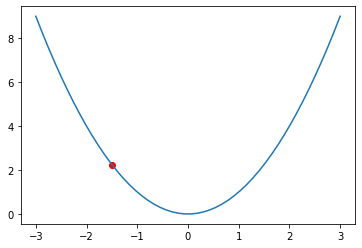

In [62]:
plot_function(f, -3, 3)
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [63]:
xt = tensor(3.).requires_grad_()

In [64]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [65]:
yt.backward()

In [66]:
xt.grad

tensor(6.)

In [67]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [68]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [69]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [111]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

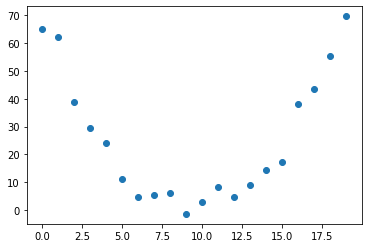

In [112]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [113]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [114]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

#### Step 1: Initialize the parameters

In [188]:
params = torch.randn(3).requires_grad_()

In [189]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [190]:
preds = f(time, params)

In [191]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-200,200)

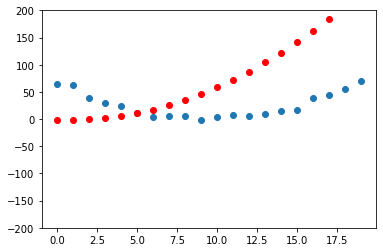

In [192]:
show_preds(preds)

#### Step 3: Calculate the loss

In [193]:
loss = mse(preds, speed)
loss

tensor(86.8252, grad_fn=<SqrtBackward0>)

#### Step 4: Calculate the gradients

In [194]:
loss.backward()
params.grad

tensor([160.2746,  10.1970,   0.5794])

In [195]:
params

tensor([ 0.7098, -1.1223, -1.2349], requires_grad=True)

#### Step 5: Step the weights. 

In [196]:
lr = 1e-3
params.data -= lr * params.grad.data
params.grad = None

In [197]:
preds = f(time,params)
mse(preds, speed)

tensor(61.5500, grad_fn=<SqrtBackward0>)

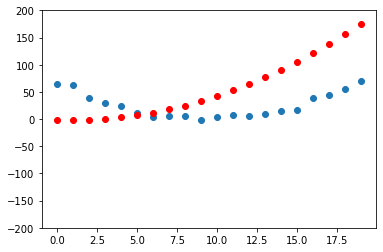

In [198]:
show_preds(preds)

In [199]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [200]:
for i in range(10): apply_step(params)

61.54996871948242
39.657657623291016
27.04892349243164
25.610620498657227
25.60746192932129
25.607162475585938
25.606895446777344
25.606626510620117
25.606355667114258
25.60608673095703


In [201]:
#hide
params = orig_params.detach().requires_grad_()

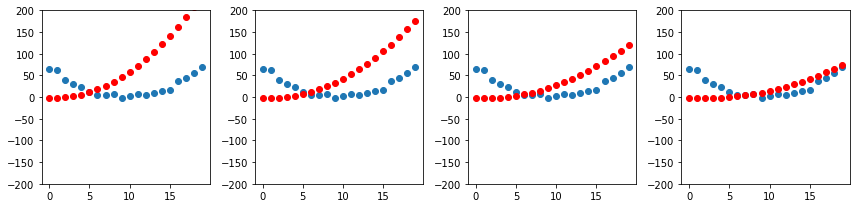

In [202]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

## The MNIST Loss Function

In [203]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [204]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [205]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [206]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [207]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [208]:
weights = init_params((28*28,1))

In [209]:
bias = init_params(1)

In [210]:
(train_x[0]*weights.T).sum() + bias

tensor([-4.3913], grad_fn=<AddBackward0>)

In [211]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -4.3913],
        [-12.0827],
        [ -5.6843],
        ...,
        [  4.6330],
        [  8.2752],
        [  6.0198]], grad_fn=<AddBackward0>)

In [212]:
corrects = (preds>0.5).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [213]:
corrects.float().mean().item()

0.2866247296333313

In [215]:
# weights[0] *= 1.0001

In [216]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.29154565930366516

In [217]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [218]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [219]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [220]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [221]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [222]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [227]:
def plot_function(f, x_min, x_max):
    x = tensor(np.linspace(x_min, x_max, 50))
    plt.plot(x, f(x))

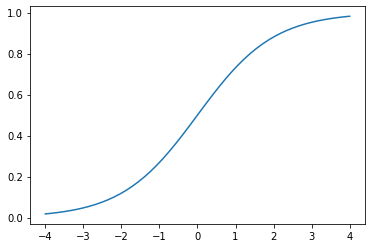

In [228]:
plot_function(torch.sigmoid, x_min=-4, x_max=4)

In [229]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [230]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 8, 13,  0,  4,  7]),
 tensor([ 9, 14,  1, 12,  2]),
 tensor([ 6, 11, 10,  3,  5])]

In [231]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [232]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 9, 19, 24,  2, 20,  6]), ('j', 't', 'y', 'c', 'u', 'g')),
 (tensor([11, 16, 23, 22, 25,  7]), ('l', 'q', 'x', 'w', 'z', 'h')),
 (tensor([14,  1, 12, 13,  8, 21]), ('o', 'b', 'm', 'n', 'i', 'v')),
 (tensor([ 0, 18,  3, 10,  5, 17]), ('a', 's', 'd', 'k', 'f', 'r')),
 (tensor([15,  4]), ('p', 'e'))]

## Putting It All Together

In [233]:
weights = init_params((28*28,1))
bias = init_params(1)

In [234]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [235]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [236]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [237]:
preds = linear1(batch)
preds

tensor([[14.7106],
        [16.6653],
        [ 2.6584],
        [10.2722]], grad_fn=<AddBackward0>)

In [238]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.0164, grad_fn=<MeanBackward0>)

In [239]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0022), tensor([-0.0153]))

In [240]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [241]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0044), tensor([-0.0306]))

In [242]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0066), tensor([-0.0459]))

In [243]:
weights.grad.zero_()
bias.grad.zero_();

In [244]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [245]:
(preds>0.0).float() == train_y[:4]

tensor([[True],
        [True],
        [True],
        [True]])

In [246]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [247]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [248]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [249]:
validate_epoch(linear1)

0.6902

In [250]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7353

In [251]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8788 0.9252 0.9408 0.9481 0.9525 0.9579 0.9598 0.9613 0.9623 0.9647 0.9672 0.9687 0.9696 0.9706 0.9711 0.973 0.974 0.975 0.9755 0.976 

### Creating an Optimizer

In [252]:
linear_model = nn.Linear(28*28,1)

In [253]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [254]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [255]:
opt = BasicOptim(linear_model.parameters(), lr)

In [256]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [257]:
validate_epoch(linear_model)

0.5029

In [258]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [259]:
train_model(linear_model, 20)

0.4932 0.6782 0.8604 0.9175 0.936 0.9502 0.9561 0.9629 0.9658 0.9678 0.9697 0.9712 0.9741 0.9746 0.9761 0.9771 0.9775 0.9775 0.9785 0.979 

In [260]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7769 0.8555 0.9165 0.9346 0.9492 0.9561 0.9639 0.9658 0.9678 0.9702 0.9717 0.9736 0.9746 0.9761 0.9775 0.9775 0.978 0.9785 0.9785 

In [261]:
dls = DataLoaders(dl, valid_dl)

In [262]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [263]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637130,0.503639,0.495584,00:00
1,0.605493,0.089115,0.945535,00:00
2,0.218422,0.246092,0.769872,00:00
3,0.094292,0.123138,0.895976,00:00
4,0.048398,0.085202,0.929343,00:00
5,0.030574,0.066531,0.943572,00:00
6,0.023290,0.055360,0.953876,00:00
7,0.020103,0.048089,0.961236,00:00
8,0.018533,0.043075,0.964671,00:00
9,0.017620,0.039439,0.967125,00:00
